In [1]:
from ipynb.fs.full.gbs import *

Matplotlib is building the font cache; this may take a moment.


# ESTU Experiment

Entanglement Sources Through Unitary

### Experimental Setup

```
                       ┌─────────────┐
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[ent]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
                       └─────────────┘
```

### QM Simulation

Let $k$ be the number of entanglement sources. 
Then, the initial state is 
$$2^{-k/2}(|HH\rangle+|VV\rangle)^{\otimes k} = 2^{-k/2}(|1010\rangle+|0101\rangle)^{\otimes k},$$
but reordered so the left (first two) modes of each ent come first, followed by all the right (second two) modes. 
Mathematically, this is 
$$\frac{1}{\sqrt{2^{k}}} \sum_{x \in S} | xx \rangle$$
Where 
$S 
:= \left\{ x \in \{0,1\}^{2k} : \forall i \in \{1, \dots, k\},\ x_{2i-1} \ne x_{2i} \right\} 
= \{01,10\}^{k}$.

We then apply a $2k \times 2k$ Haar-random unitary $U_\text{haar}$ to the right modes by applying the $4k \times 4k$ unitary $U = I \oplus U_\text{haar}$.

Note that there are $2k$ photons in the system, with $k$ of those passing through $U_\text{haar}$, and no mode has more than one photon in it initially.


In [2]:
def get_lossless_estu_heralds(num_src):
    n = num_src
    m = 2*num_src
    
    all_possible_heralds = []
    for i in range(2**n):
        state = [0]*m
        for digit in range(n):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            i >>= 1
        all_possible_heralds.append(tuple(state))
        
    return all_possible_heralds

In [3]:
def qm_estu(U, heralds):
    '''Simulates Quantum Mechanical predictions of detection event likelyhoods
    resulting from passing heralded states through the provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.'''

    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    hsu = {}

    for initial_state in heralds:
        
        n = sum(initial_state)
        if n not in hsu:
            hsu[n] = HilbertSpaceUnitary(U, n)
        final_state = hsu[n].apply(initial_state)
        
        for fock_outcome in final_state:
            amp = final_state[fock_outcome]
            probability = amp * conj(amp)
            det_event = tuple([(1 if photon_num > 0 else 0) for photon_num in fock_outcome])
            qm_distrs[initial_state][det_event] += probability
    
    return qm_distrs

In [4]:
def stoch_estu(
    U, 
    heralds, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000
):
    '''Simulates Stochastic Mechanical predictions of detection event likelyhoods
    resulting from heralding provided states and applying provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.
    r : float
        = squeezing strength.
    herald_gamma : float
        = measurement threshold for heralding detectors.
    out_gamma : float
        = measurement threshold for output detectors.
    N : int
        = number of samples.'''
    
    # TODO: change asserts to proper error handling
    m = len(heralds[0])
    assert(m % 2 == 0)
    assert(all([len(herald) == m for herald in heralds]))
    num_src = m // 2
    
    ents = [ent(N, r=r) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents, herald_gamma)
    dr = threshold_detector(r_ents, out_gamma)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.astype(int).T[herald_mask]))
        stoch_normalization = 0
        for det_event in counts.keys():
            stoch_distrs[herald][det_event] = counts[det_event]
            stoch_normalization += counts[det_event]
        if stoch_normalization != 0:
            for det_event in stoch_distrs[herald]:
                stoch_distrs[herald][det_event] /= stoch_normalization
                
    return stoch_distrs

In [5]:
def plot_qm_vs_stoch(qm_distrs, stoch_distrs):
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys())
        
    for herald in heralds:
        all_det_events = set()
        all_det_events.update(qm_distrs[herald].keys(), stoch_distrs[herald].keys())
        
        distrs_sorted = []
        for det_event in all_det_events:
            distrs_sorted.append(
                (qm_distrs[herald][det_event], 
                 stoch_distrs[herald][det_event], 
                 ''.join(map(str,det_event)))
            )
        distrs_sorted = sorted(distrs_sorted)
    
        labels = []
        qm_data = []
        stoch_data = []
        for qm_pt, stoch_pt, det_event in distrs_sorted:
            labels.append(det_event)
            qm_data.append(qm_pt)
            stoch_data.append(stoch_pt)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, qm_data, width, label='QM', color='gray')
        rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof', color='orangered')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Probabilities')
        ax.set_title(f'Comparing QM and Spoof, Heralding {herald}')
        ax.set_xticks(x, labels, rotation=90)
        ax.legend()

        #ax.bar_label(rects1, padding=3)
        #ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()

In [6]:
def hellinger_dist(p, q):
    p = np.array(p)
    q = np.array(q)
    return np.linalg.norm(sqrt(p) - sqrt(q)) / sqrt(2)

In [7]:
def avg_distr_distance(qm_distrs, stoch_distrs):
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys())
    
    hellinger_dists = []
    
    for herald in heralds:
        all_det_events = set()
        all_det_events.update(qm_distrs[herald].keys(), stoch_distrs[herald].keys())
        obs_pr_distr = []
        exp_pr_distr = []
        for det_event in all_det_events:
            obs_pr_distr.append(stoch_distrs[herald][det_event])
            exp_pr_distr.append(qm_distrs[herald][det_event])
        hellinger_dists.append(hellinger_dist(obs_pr_distr, exp_pr_distr))
        
    return sum(hellinger_dists) / len(hellinger_dists)

In [8]:
def estu(
    num_src,
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    '''Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary to all possible 
    lossless heralds. No postselection. Converts Fock states
    to 0/1 detection events.'''
    
    n = num_src     # each ent sends one photon to the right
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    
    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    if heralds is None:
        heralds = get_lossless_estu_heralds(num_src)
    
    qm_distrs = qm_estu(U, heralds)
    stoch_distrs = stoch_estu(U, heralds, r, herald_gamma, out_gamma, N)

    return qm_distrs, stoch_distrs

In [9]:
def print_estu(
    num_src,
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    qm_distrs, stoch_distrs = estu(num_src, U, heralds, r, herald_gamma, out_gamma, N)
    avg_dist = avg_distr_distance(qm_distrs, stoch_distrs)
    print(f"Average Hellinger Distance {avg_dist}")
    plot_qm_vs_stoch(qm_distrs, stoch_distrs)

In [10]:
def optimizable_estu(x, num_src=3, U=None, heralds=None, N=100000, shots=10):
    running_tot = 0
    for i in range(shots):
        qm_distrs, stoch_distrs = estu(
            num_src, 
            U=U,
            heralds=heralds,
            r=x[0], 
            herald_gamma=x[1], 
            out_gamma=x[2], 
            N=N
        )
        running_tot += avg_distr_distance(qm_distrs, stoch_distrs)
    return running_tot / shots

## Tests

In [11]:
# Defining a few unitaries for quick experimentation
I1 = np.eye(1)
I2 = np.eye(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = -1j * Z @ X
hadamard = np.array([[1, 1], [1, -1]]) / sqrt(2)

Average Hellinger Distance 0.28724553339925013


/u/ronakr/installations/envs/arl-gbs/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


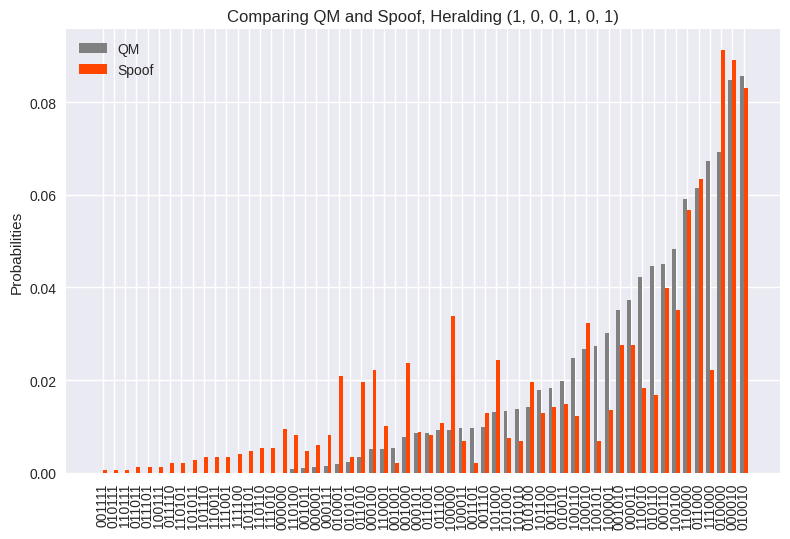

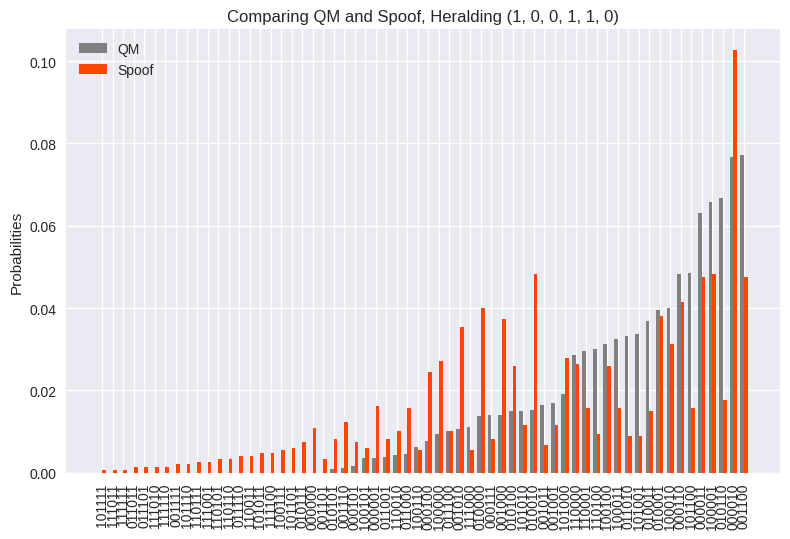

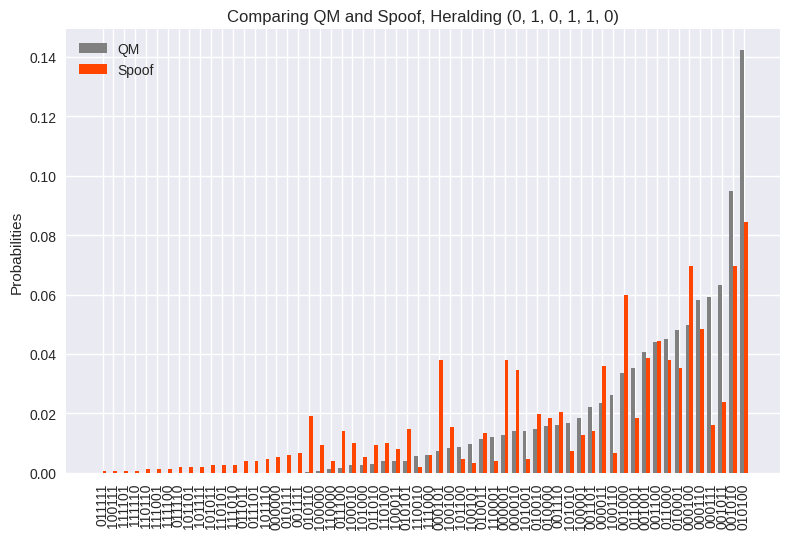

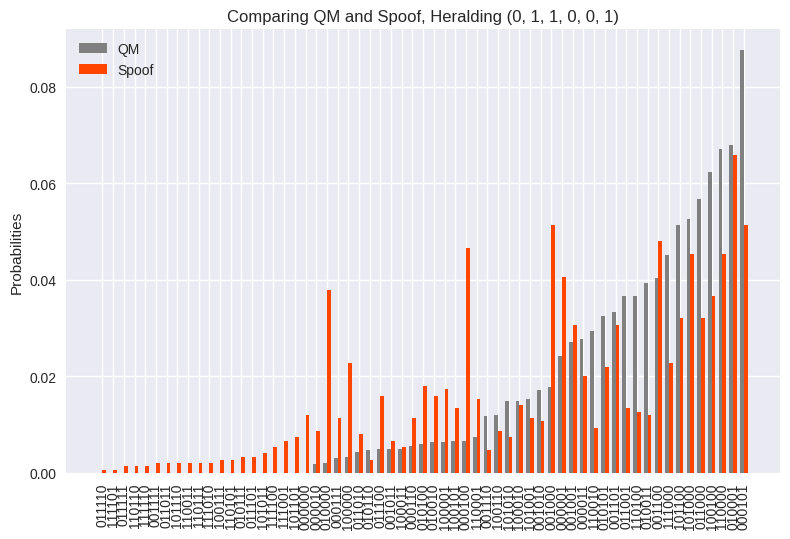

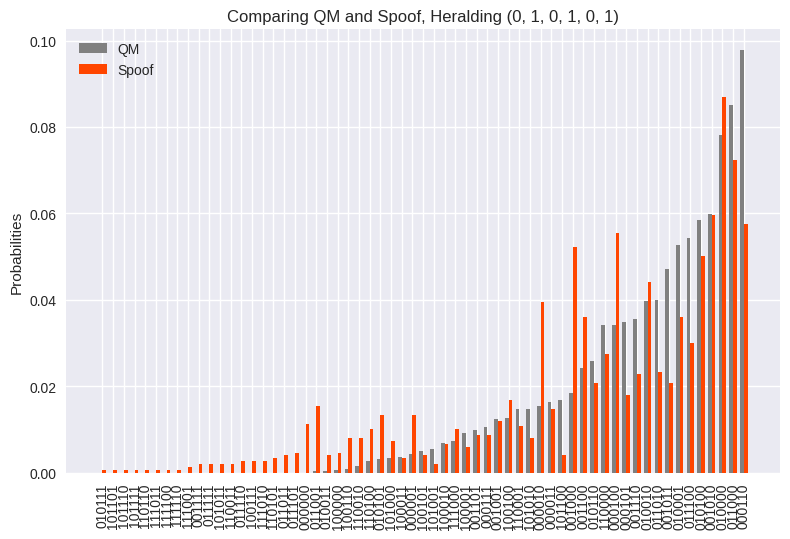

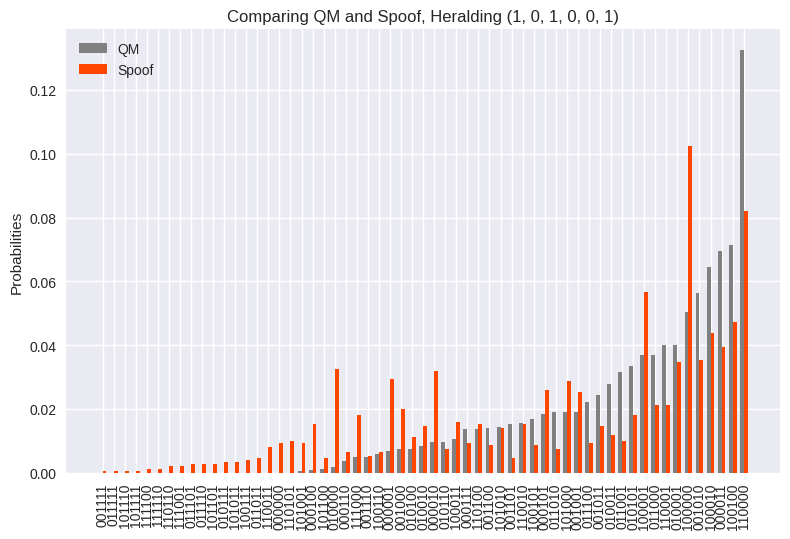

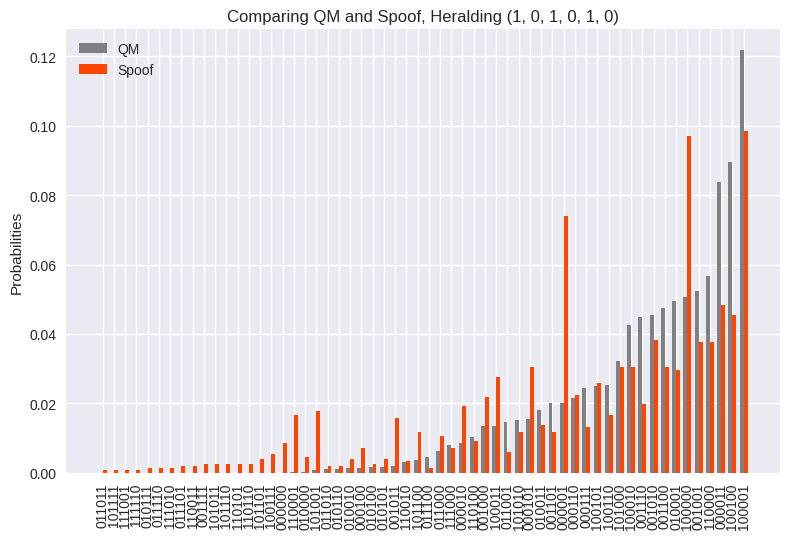

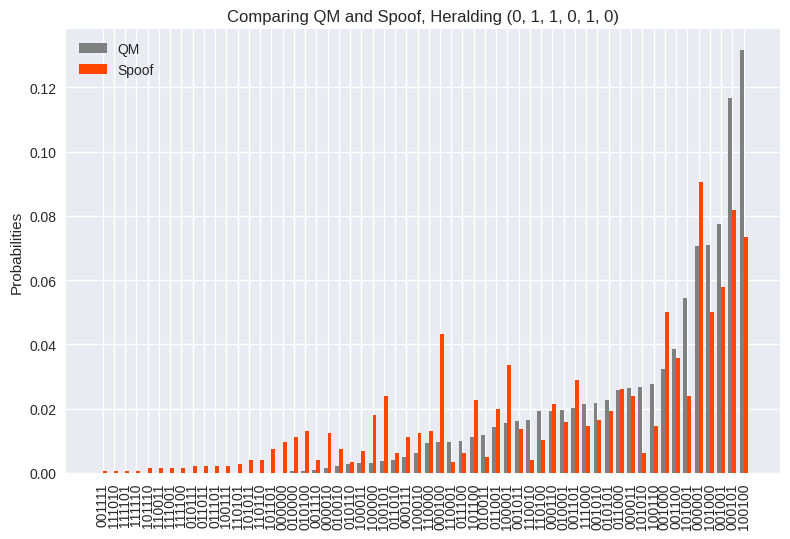

In [12]:
print_estu(3)

Average Hellinger Distance 0.4717783851999877


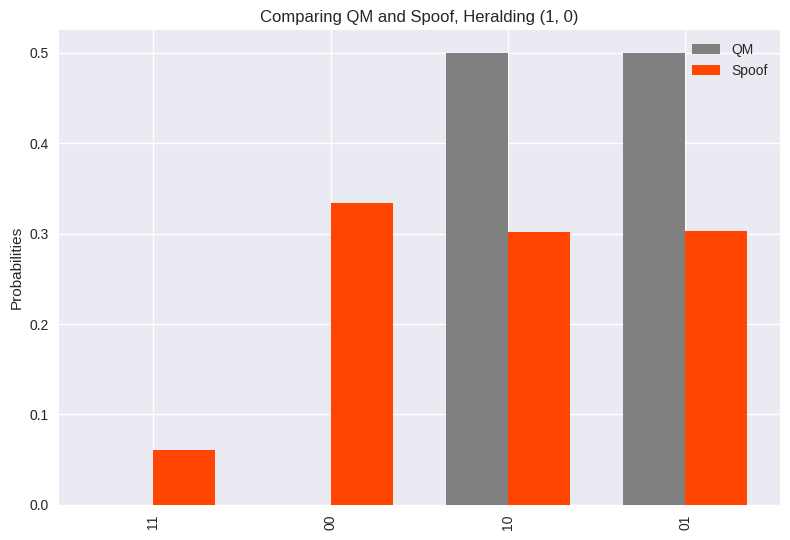

In [13]:
# Basic Hadamard
print_estu(1, U=hadamard, heralds=[(1,0)], N=1000000)

Average Hellinger Distance 0.36375630190185365


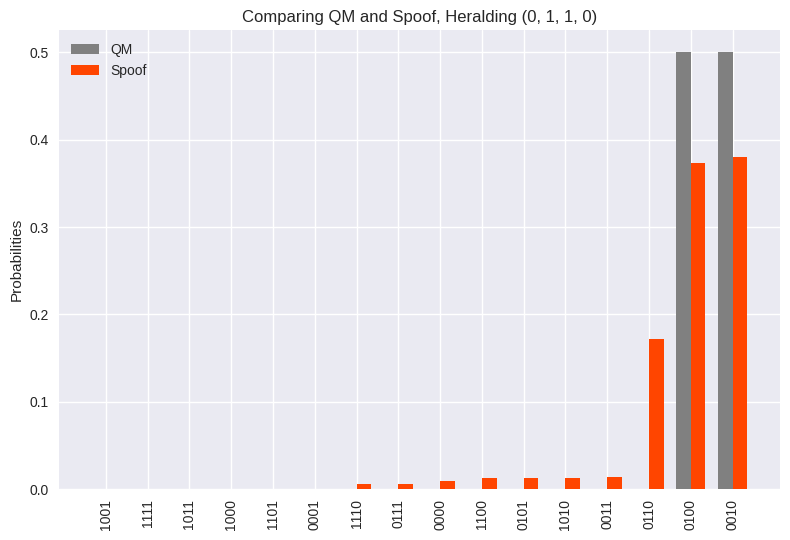

In [14]:
# Hong-Ou-Mandel Experiment
U = direct_sum(I1, hadamard, I1)
print_estu(2, U=U, heralds=[(0,1,1,0)], N=1000000)

### Haar-Random Unitary

In [15]:
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, method='Nelder-Mead', tol=1e-2)
res.x

array([1.09320988, 1.86637   , 1.92894333])

In [16]:
print(optimizable_estu(res.x))

0.2988358832933754


Average Hellinger Distance 0.3030714594245213


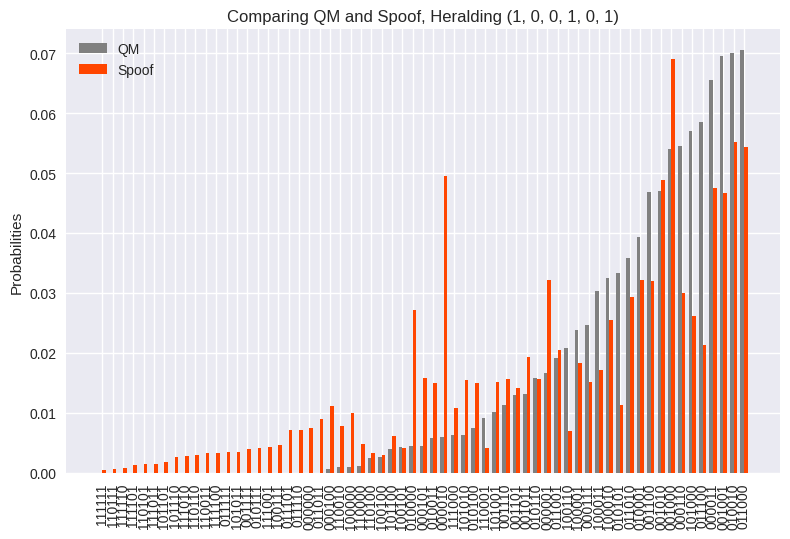

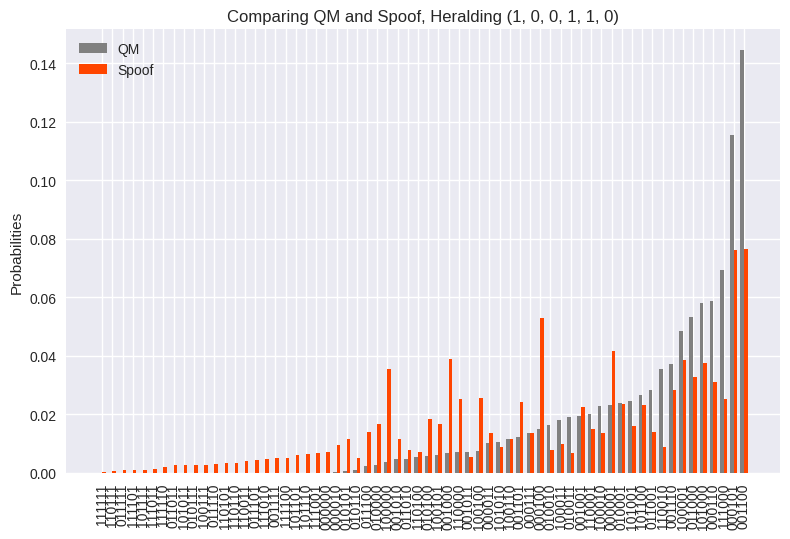

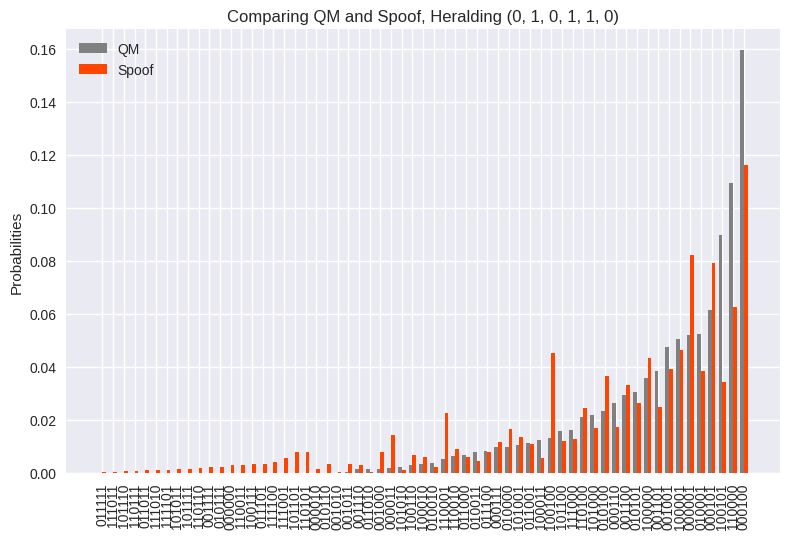

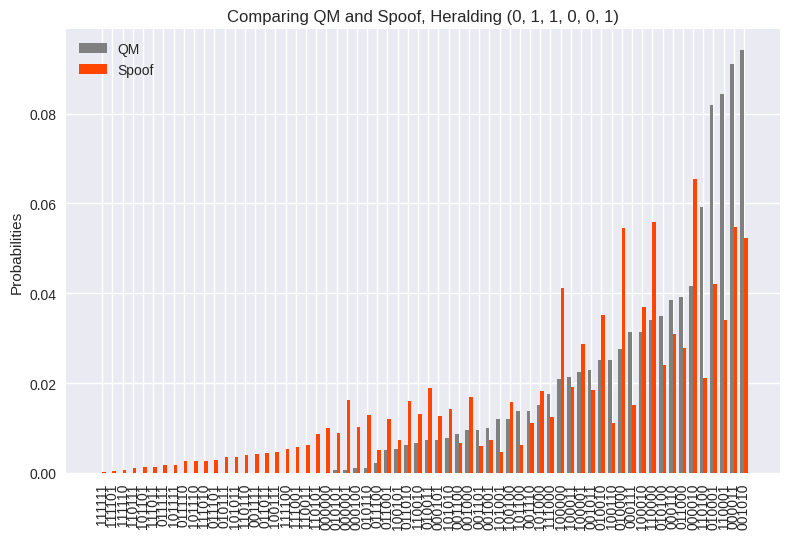

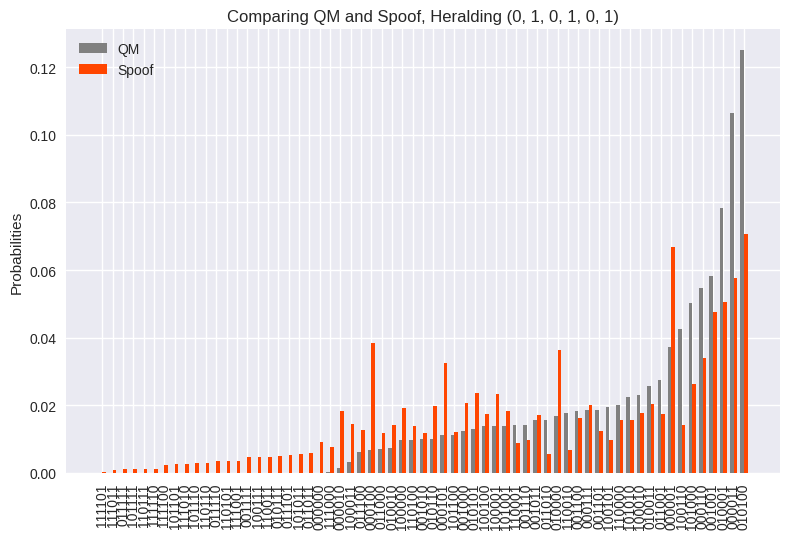

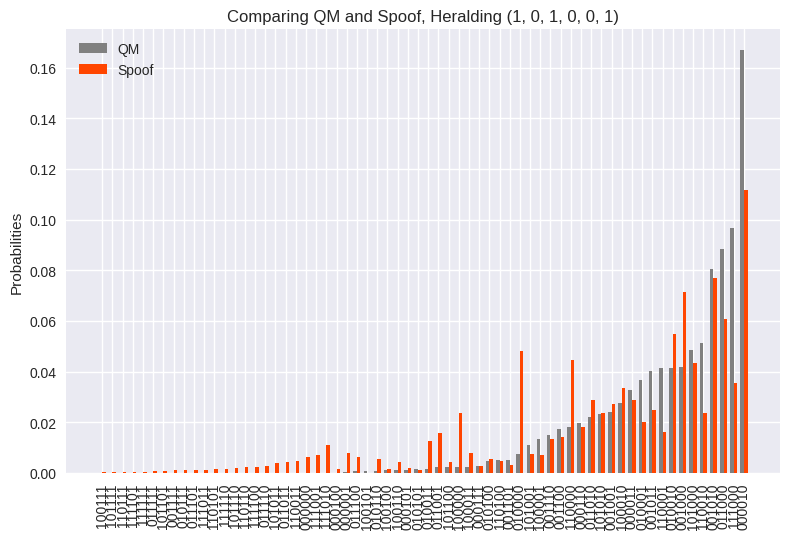

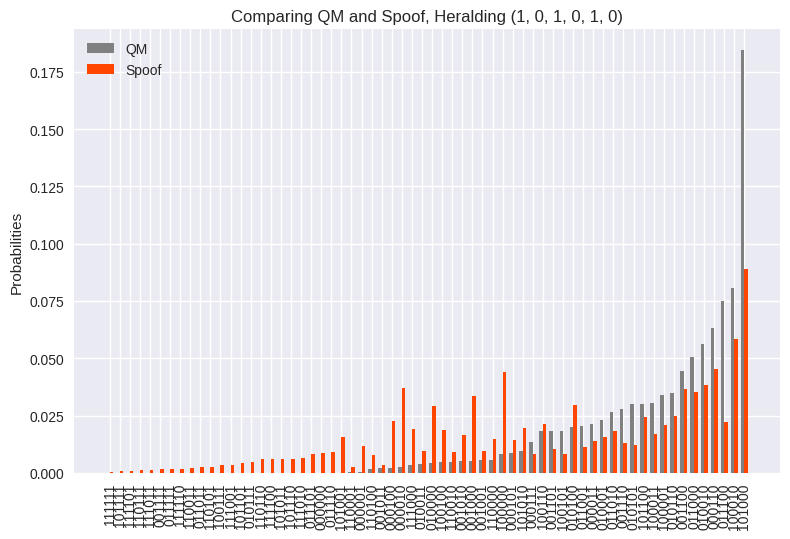

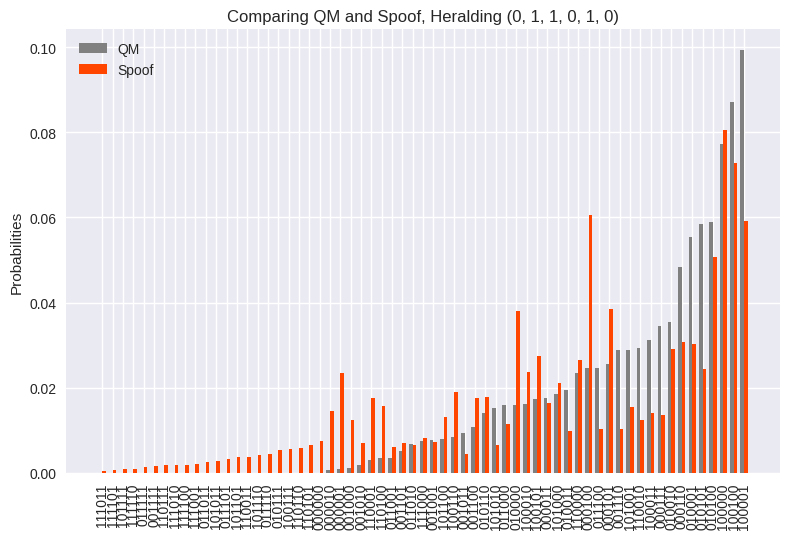

In [17]:
print_estu(
    3, 
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [18]:
# past optimizations
print(optimizable_estu([1.08297325, 1.70032542, 1.82342849]))
print(optimizable_estu([1.1055373 , 1.82534494, 1.88541628]))

0.31213910109935483
0.3101536412868289


### Basic Hadamard

In [19]:
# Optimizing Basic Hadamard
U = direct_sum(I1, hadamard, I1)
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, 
               args=(1, hadamard, [(1,0)], 100000, 3), 
               method='Nelder-Mead', tol=1e-2)
res.x

array([1.03640287, 2.096484  , 1.83066014])

0.40165508562116337
Average Hellinger Distance 0.4018251924283642


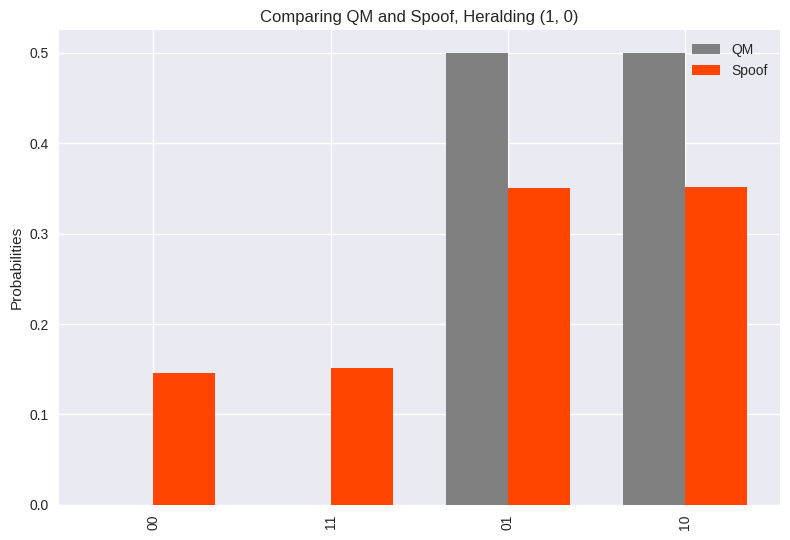

In [20]:
print(optimizable_estu(res.x, 1, hadamard, [(1,0)], 100000, 10))
print_estu(
    1,
    U=hadamard,
    heralds=[(1,0)],
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [21]:
# past optimizations
print(optimizable_estu([1.03529492, 2.11390389, 1.81540191], 1, hadamard, [(1,0)], 100000, 10))

0.39934708422463394


### Hong-Ou Mandel

In [22]:
# Optimizing Hong-Ou-Mandel
U = direct_sum(I1, hadamard, I1)
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, 
               args=(2, U, [(0,1,1,0)], 1000000, 10), 
               method='Nelder-Mead', tol=1e-2)
res.x

array([0.80683963, 2.11702785, 2.21528769])

0.277914359960963
Average Hellinger Distance 0.278554381542761


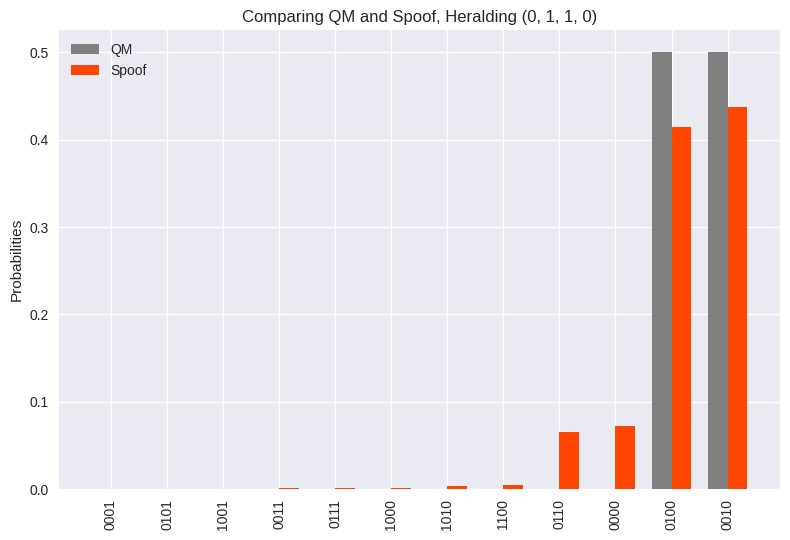

In [23]:
print(optimizable_estu(res.x, 2, U, [(0,1,1,0)], 100000, 10))
print_estu(
    2,
    U=U,
    heralds=[(0,1,1,0)],
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [24]:
# past optimizations
print(optimizable_estu([0.98920348, 1.85728697, 2.08022861], 2, U, [(0,1,1,0)], 1000000, 10)) # found with N=100000, shots=3
print(optimizable_estu([0.86703834, 2.05445921, 2.21177043], 2, U, [(0,1,1,0)], 1000000, 10)) # found with N=100000, shots=10

0.292755423555011
0.27657850368491904
